# S&P 500 ML Analysis Testing

### Imports

In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras import metrics
from keras import backend as K
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from random import randint

### Load and Clean Dataset

In [96]:
df = pd.read_csv("./Datasets/S&P500.csv")
nulls = df.isnull().sum().sum() + df.isna().sum().sum()
boolSeries = df.duplicated().to_numpy()
if ((boolSeries.sum() == 0) and (nulls == 0)):
    print("Dataset is clean!")
else:
    print("Dataset is dirty!")

Dataset is clean!


### Split Dataset

In [97]:
exposureSize = 365
splitDate = '2017-05-16'

trainingDataUnscaled = df[df['Date'] <= splitDate].copy()
trainingDataUnscaled.drop(['Date', 'Adj Close'], axis=1, inplace=True)

testingDataUnscaled = df[df['Date'] > splitDate].copy()
dates = testingDataUnscaled['Date'].copy()
previousDays = trainingDataUnscaled.tail(exposureSize)
testingDataUnscaled = pd.concat([previousDays, testingDataUnscaled], ignore_index=True)
testingDataUnscaled.drop(['Date', 'Adj Close'], axis=1, inplace=True)

### Preprocessing

In [98]:
scaler = StandardScaler()
anotherScaler = MinMaxScaler()
trainingDataStandardised = scaler.fit_transform(trainingDataUnscaled)
trainingDataNormalised = anotherScaler.fit_transform(trainingDataStandardised)
testingDataStandardised = scaler.transform(testingDataUnscaled)
testingDataNormalised = anotherScaler.transform(testingDataStandardised)

### Build Input and Output Series

In [99]:
lookAhead = 1
offset = lookAhead - 1
X_train, y_train, X_test, y_test = [], [], [], []

for i in range(exposureSize, trainingDataNormalised.shape[0]-offset):
    X_train.append(trainingDataNormalised[i-exposureSize:i])
    y_train.append(trainingDataNormalised[i+offset, 3])

for j in range(exposureSize, testingDataNormalised.shape[0]-offset):
    X_test.append(testingDataNormalised[j-exposureSize:j])
    y_test.append(testingDataNormalised[j+offset, 3])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

print("X_train: ")
print(X_train.shape)
print("y_train: ")
print(y_train.shape)
print("X_test: ")
print(X_test.shape)
print("y_test: ")
print(y_test.shape)

X_train: 
(3912, 365, 5)
y_train: 
(3912,)
X_test: 
(627, 365, 5)
y_test: 
(627,)


### Coefficient of Determination Function

In [100]:
# REF: https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def coefficient_of_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

### Model Definition

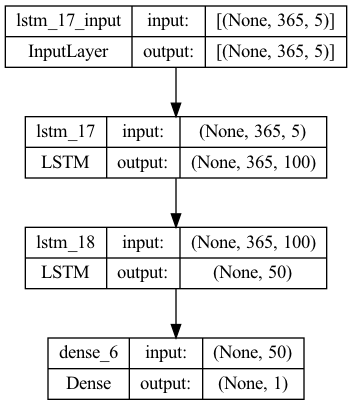

In [101]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
optimiser = Adam(learning_rate=0.01)
model.compile(loss='mae', optimizer=optimiser, metrics=[metrics.MeanAbsoluteError(), metrics.MeanSquaredError(), metrics.RootMeanSquaredError(), coefficient_of_determination])
plot_model(model, show_shapes=True)

### Training

In [102]:
historyOne = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_test, y_test), verbose=1)
K.set_value(model.optimizer.learning_rate, 0.001)
historyTwo = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_test, y_test), verbose=1)
K.set_value(model.optimizer.learning_rate, 0.0001)
historyThree = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/4
123/123 [==============================] - 87s 680ms/step - loss: 0.0435 - mean_absolute_error: 0.0435 - mean_squared_error: 0.0132 - root_mean_squared_error: 0.1147 - coefficient_of_determination: 0.7745 - val_loss: 0.0398 - val_mean_absolute_error: 0.0398 - val_mean_squared_error: 0.0025 - val_root_mean_squared_error: 0.0503 - val_coefficient_of_determination: -3.8465
Epoch 2/4
123/123 [==============================] - 83s 670ms/step - loss: 0.0170 - mean_absolute_error: 0.0170 - mean_squared_error: 5.0884e-04 - root_mean_squared_error: 0.0226 - coefficient_of_determination: 0.9903 - val_loss: 0.0273 - val_mean_absolute_error: 0.0273 - val_mean_squared_error: 0.0010 - val_root_mean_squared_error: 0.0322 - val_coefficient_of_determination: -4.2660
Epoch 3/4
123/123 [==============================] - 78s 630ms/step - loss: 0.0168 - mean_absolute_error: 0.0168 - mean_squared_error: 5.0766e-04 - root_mean_squared_error: 0.0225 - coefficient_of_determination: 0.9904 - val_loss:

### Predict

In [103]:
y_hat = model.predict(X_test)

20/20 [==============================] - 14s 681ms/step


### Unscale Data

In [104]:
# Undo normalisation
y_test = (y_test * anotherScaler.data_range_[0]) + anotherScaler.data_min_[0]
y_hat = (y_hat * anotherScaler.data_range_[0]) + anotherScaler.data_min_[0]
# Undo standardisation
y_test = (y_test * scaler.scale_[0]) + scaler.mean_[0]
y_hat = (y_hat * scaler.scale_[0]) + scaler.mean_[0]

### Plot Prediction

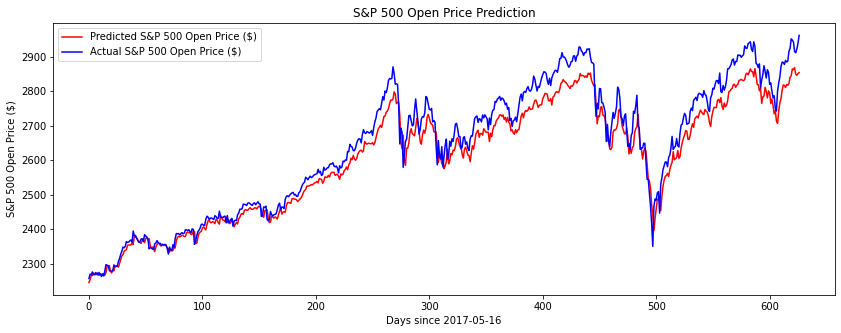

In [105]:
plt.figure(figsize=(14, 5))
plt.plot(y_hat, color='red', label="Predicted S&P 500 Open Price ($)")
plt.plot(y_test, color='blue', label="Actual S&P 500 Open Price ($)")
plt.title('S&P 500 Open Price Prediction')
# plt.xticks(np.arange(dates.shape[0]), dates)
xLabel = "Days since " + splitDate
plt.xlabel(xLabel)
plt.ylabel('S&P 500 Open Price ($)')
plt.legend()
plt.show()

### Performance Metrics

In [106]:
mae = historyThree.history['mean_absolute_error']
mse = historyThree.history['mean_squared_error']
rmse = historyThree.history['root_mean_squared_error']
r2 = historyThree.history['coefficient_of_determination']

print('Mean Absolute Error (MAE): ' + str(mae[-1]))
print('Mean Squared Error (MSE): ' + str(mse[-1]))
print('Root Mean Squared Error (RMSE): ' + str(rmse[-1]))
print('Coefficient of Determination (R2): ' + str(r2[-1]))

Mean Absolute Error (MAE): 0.007294893264770508
Mean Squared Error (MSE): 0.00010382960317656398
Root Mean Squared Error (RMSE): 0.010189681313931942
Coefficient of Determination (R2): 0.9979273676872253


In [107]:
valmae = historyThree.history['val_mean_absolute_error']
valmse = historyThree.history['val_mean_squared_error']
valrmse = historyThree.history['val_root_mean_squared_error']
valr2 = historyThree.history['val_coefficient_of_determination']

print('Validation Mean Absolute Error (MAE): ' + str(valmae[-1]))
print('Validation Mean Squared Error (MSE): ' + str(valmse[-1]))
print('Validation Root Mean Squared Error (RMSE): ' + str(valrmse[-1]))
print('Validation Coefficient of Determination (R2): ' + str(valr2[-1]))

Validation Mean Absolute Error (MAE): 0.023807689547538757
Validation Mean Squared Error (MSE): 0.0008380339131690562
Validation Root Mean Squared Error (RMSE): 0.028948815539479256
Validation Coefficient of Determination (R2): -0.6703802943229675


### Trading Strategy

In [108]:
initialBalance = 1000000
actionThreshold = 0.01
sentimentInfluence = 0.005
betProportion = 1

# Random strategy
controlBalance = initialBalance
controlOwnedShares = 0
controlBet = controlBalance / betProportion
controlBuyOrders = 0
controlSellOrders = 0

# Trading the price predictions
balance = initialBalance
ownedShares = 0
bet = balance / betProportion
buyOrders = 0
sellOrders = 0

def Buy(price, bet, balance, ownedShares):
    if (balance > 0):
            numShares = 0
            if (balance >= bet):
                numShares = bet / price
                balance -= bet
                ownedShares += numShares
            else:
                numShares = balance / price
                balance = 0
                ownedShares += numShares
            # print("BUY - " + str(numShares) + " shares at $" + str(price))
            bet = (balance + (ownedShares * price)) / betProportion
    return bet, balance, ownedShares

def Sell(price, bet, balance, ownedShares):
    if (ownedShares > 0):
        numShares = bet / price
        if (ownedShares >= numShares):
            balance += bet
            ownedShares -= numShares
            # print("SELL - " + str(numShares) + " shares at $" + str(price))
        else:
            value = ownedShares * price
            balance += value
            ownedShares = 0
            # print("SELL - " + str(ownedShares) + " shares at $" + str(price))
        bet = (balance + (ownedShares * price)) / betProportion
    return bet, balance, ownedShares

# Random trading strategy
for i in range(len(y_hat)-1):
    if (randint(0, 1) == 0): # ! Buy
        controlBet, controlBalance, controlOwnedShares = Buy(y_test[i], controlBet, controlBalance, controlOwnedShares)
    else: # ! Sell
        controlBet, controlBalance, controlOwnedShares = Sell(y_test[i], controlBet, controlBalance, controlOwnedShares)

# Trading strategy based on price prediction
for i in range(len(y_hat)-1):
    
    currentPrice = y_test[i]
    predictedPrice = y_hat[i+1]
    difference = predictedPrice - currentPrice
    percentageChange = difference / currentPrice

    # No sentiment
    if (abs(percentageChange) < actionThreshold): # ! Hold
        pass
    elif (currentPrice < predictedPrice): # ! Buy
        bet, balance, ownedShares = Buy(y_test[i], bet, balance, ownedShares)
    elif (currentPrice > predictedPrice): # ! Sell
        bet, balance, ownedShares = Sell(y_test[i], bet, balance, ownedShares)

controlTotalShareValue = controlOwnedShares * y_test[-1]
controlFinalBalance = controlBalance + controlTotalShareValue
controlProfit = controlFinalBalance-initialBalance
controlBalancePercentageChange = ((controlFinalBalance-initialBalance)/initialBalance) * 100

totalShareValue = ownedShares * y_test[-1]
finalBalance = balance + totalShareValue
profit = finalBalance-initialBalance
balancePercentageChange = ((finalBalance-initialBalance)/initialBalance) * 100

pricePercentageChange = ((y_test[-1]-y_test[0])/y_test[0]) * 100

print("----------------------------------------------------------------")

print("Trading over " + str(y_hat.shape[0]) + " days")
print("Initial Balance: $" + str(initialBalance))

print("----------------------------------------------------------------")

print("Random Trading Strategy")
# print("Final Balance: $" + str(controlFinalBalance))
print("Profit: $" + str(controlProfit))
print("Balance Percentage Change: " + str(controlBalancePercentageChange) + "%")

print("----------------------------------------------------------------")

print("Buying on day one and holding")
print("Profit: $" + str(initialBalance * (pricePercentageChange/100)))
print("Balance Percentage Change: " + str(pricePercentageChange) + "%")

print("----------------------------------------------------------------")

print("Trading strategy based on price predictions")
# print("Final Balance: $" + str(finalBalance))
print("Profit: $" + str(profit))
print("Balance Percentage Change: " + str(balancePercentageChange) + "%")

print("----------------------------------------------------------------")

----------------------------------------------------------------
Trading over 627 days
Initial Balance: $1000000
----------------------------------------------------------------
Random Trading Strategy
Profit: $160595.90794289205
Balance Percentage Change: 16.059590794289207%
----------------------------------------------------------------
Buying on day one and holding
Profit: $312298.63939187676
Balance Percentage Change: 31.229863939187673%
----------------------------------------------------------------
Trading strategy based on price predictions
Profit: $49923.620693730656
Balance Percentage Change: 4.9923620693730655%
----------------------------------------------------------------
